# Use this notebook to plot spectrum data on the chromaticity graph

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


Loaded CSV files: ['A1.csv', 'A2.csv', 'A3.csv', 'A4.csv', 'A5.csv', 'A6.csv', 'A7.csv', 'A8.csv', 'B1.csv', 'B2.csv', 'B3.csv', 'B4.csv', 'B5.csv', 'B6.csv', 'B7.csv', 'B8.csv', 'C1.csv', 'C2.csv', 'C3.csv', 'C4.csv', 'C5.csv', 'C6.csv', 'C7.csv', 'C8.csv', 'D1.csv', 'D2.csv', 'D3.csv', 'D4.csv', 'D5.csv', 'D6.csv', 'D7.csv', 'D8.csv', 'E1.csv', 'E2.csv', 'E3.csv', 'E4.csv', 'E5.csv', 'E6.csv', 'E7.csv', 'F1.csv', 'F2.csv', 'F3.csv', 'F4.csv', 'F5.csv', 'F6.csv', 'F7.csv', 'G1.csv', 'G2.csv', 'G3.csv', 'G4.csv', 'G5.csv', 'G6.csv', 'G7.csv', 'H1.csv', 'H2.csv', 'H3.csv', 'H4.csv', 'H5.csv', 'H6.csv', 'H7.csv']


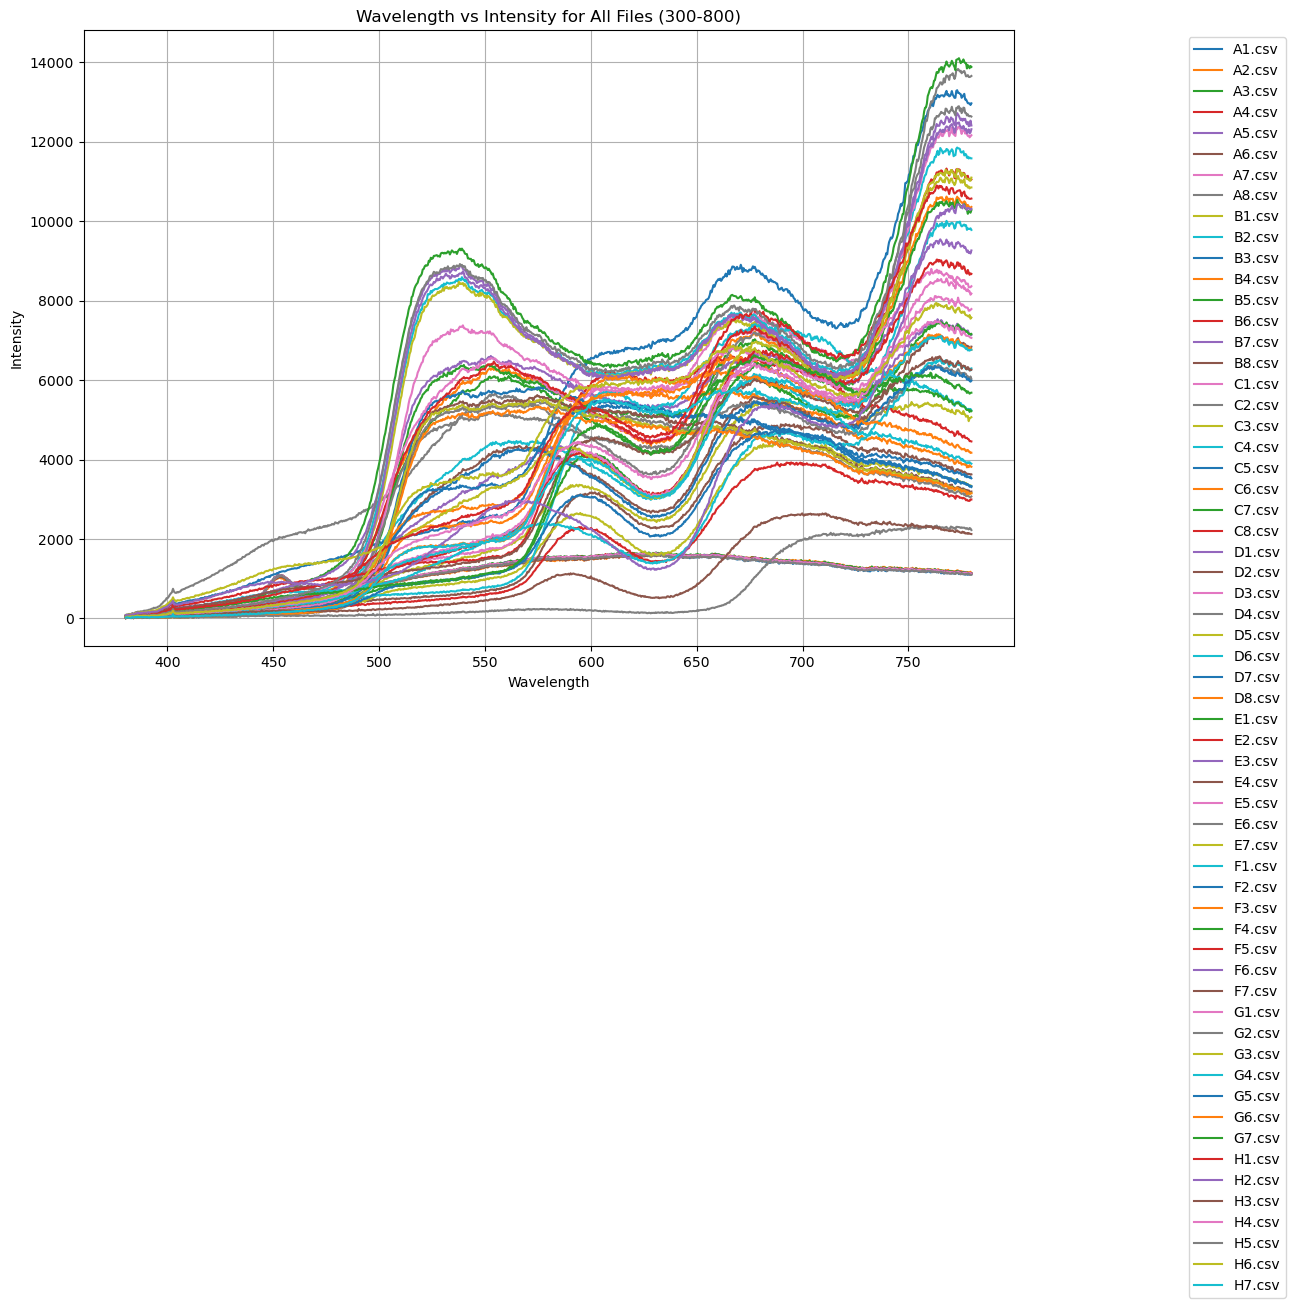

In [6]:
# Import CSV files from the data folder

data_folder = "datatemp"
# Only include files that end with .csv and match the expected pattern (e.g., "A1.csv", "C1.csv")
csv_files = sorted(
    [file for file in os.listdir(data_folder) if file.endswith('.csv')],
    key=lambda x: x
)

# Load all CSV files into a dictionary of DataFrames
dataframes = {file: pd.read_csv(os.path.join(data_folder, file), skiprows=1, names=["wavelength", "intensity"]) for file in csv_files}

# Display the names of the loaded files
print(f"Loaded CSV files: {list(dataframes.keys())}")

# Plot the wavelength and intensity for the selected file within the range 300 to 800
plt.figure(figsize=(12, 8))
for file, df in dataframes.items():
    filtered_df = df[(df['wavelength'] >= 380) & (df['wavelength'] <= 780)]
    plt.plot(filtered_df['wavelength'], filtered_df['intensity'], label=file)

plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Wavelength vs Intensity for All Files (300-800)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()



In [3]:
import numpy as np
import colour
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
from skimage import color
from colour import MSDS_CMFS, colorimetry, XYZ_to_sRGB, XYZ_to_xy
from skimage.color import xyz2rgb as color_xyz2rgb  # Use skimage's version here
from matplotlib.path import Path

def load_cie_1931_cmf():
    """Returns standard CIE 1931 CMFs: wavelengths (nm), x̄, ȳ, z̄"""
    # Load the CIE 1931 2-degree color matching functions
    cmfs = colour.MSDS_CMFS['cie_2_1931']

    # Access the data as a NumPy array
    wavelengths = cmfs.wavelengths
    x_bar = cmfs.values[:, 0]
    y_bar = cmfs.values[:, 1]
    z_bar = cmfs.values[:, 2]
    return wavelengths, x_bar, y_bar, z_bar

def spectrum_to_xy(wavelengths, intensities):
    """
    Convert measured spectrum (wavelengths and intensities) to CIE 1931 x, y chromaticity.
    
    Parameters:
    - wavelengths: numpy array of wavelengths (nm)
    - intensities: numpy array of spectral intensities
    
    Returns:
    - x, y: chromaticity coordinates
    """
    lam_cie, x_bar, y_bar, z_bar = load_cie_1931_cmf()

    # Interpolate measured spectrum to CMF wavelengths
    I_interp = np.interp(lam_cie, wavelengths, intensities, left=0, right=0)

    # Compute tristimulus values
    X = np.sum(I_interp * x_bar)
    Y = np.sum(I_interp * y_bar)
    Z = np.sum(I_interp * z_bar)

    # Normalize to get chromaticity coordinates
    total = X + Y + Z
    if total == 0:
        return 0.0, 0.0  # Avoid division by zero
    x = X / total
    y = Y / total

    return x, y

def get_spectral_locus_path():
    """Return spectral locus as a Path object for masking."""
    lam, x_bar, y_bar, z_bar = load_cie_1931_cmf()
    XYZ = np.stack([x_bar, y_bar, z_bar], axis=1)
    XYZ_sum = np.sum(XYZ, axis=1, keepdims=True)
    xy = XYZ / XYZ_sum
    return Path(xy[:, :2])  # convert to Path

def plot_chromaticity_diagram():
    lam, x_bar, y_bar, z_bar = load_cie_1931_cmf()
    
    # Normalize to chromaticity
    XYZ = np.stack([x_bar, y_bar, z_bar], axis=1)
    XYZ_sum = np.sum(XYZ, axis=1, keepdims=True)
    chromaticity = XYZ / XYZ_sum

    # plt.figure(figsize=(8, 8))
    plt.plot(chromaticity[:, 0], chromaticity[:, 1], 'k-', label='Spectral Locus') # This the the horse shoe shape
    # plt.fill(chromaticity[:, 0], chromaticity[:, 1], color='lightgray', alpha=0.5)
    
    # sRGB triangle
    sRGB_xy = np.array([
        [0.64, 0.33],  # R
        [0.30, 0.60],  # G
        [0.15, 0.06],  # B
        [0.64, 0.33]   # Close
    ])
    plt.plot(sRGB_xy[:, 0], sRGB_xy[:, 1], 'k--', label='sRGB gamut') # This is the triangle

    plt.title('CIE 1931 Chromaticity Diagram')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis([0, 0.8, 0, 0.9])
    plt.grid(True)
    plt.legend()


def xy_to_XYZ(x, y, Y=1.0):
    """Convert (x, y) chromaticity to XYZ color with luminance Y."""
    X = (x * Y) / y
    Z = ((1 - x - y) * Y) / y
    return np.stack([X, Y * np.ones_like(x), Z], axis=-1)

def generate_cie_1931_background(res=0.001):
    """Generate RGB-filled CIE 1931 background image in x-y space."""
    x = np.arange(0, 0.8, res)
    y = np.arange(0, 0.9, res)
    xx, yy = np.meshgrid(x, y)
    mask = (xx + yy) <= 1  # only keep valid chromaticity points

    # Convert (x, y) → XYZ
    XYZ = xy_to_XYZ(xx, yy)
    XYZ[~mask] = 0

    # Convert XYZ to RGB
    RGB = color.xyz2rgb(XYZ)

    # # Constrain RGB values to valid range
    RGB[RGB < 0] = 0
    RGB[RGB > 1] = 1
    RGB[~mask] = 1  # White background outside valid gamut

    return xx, yy, RGB



File: A1.csv, Chromaticity coordinates (x, y): (0.41002809047984184, 0.40189977925382275)
File: A2.csv, Chromaticity coordinates (x, y): (0.41203210931445905, 0.4024580633202329)
File: A3.csv, Chromaticity coordinates (x, y): (0.41144584537829343, 0.4029902730963833)
File: A4.csv, Chromaticity coordinates (x, y): (0.4111265139818438, 0.40254270813560633)
File: A5.csv, Chromaticity coordinates (x, y): (0.4108942052071075, 0.40284022351127735)
File: A6.csv, Chromaticity coordinates (x, y): (0.41121605379173226, 0.40264472119215666)
File: A7.csv, Chromaticity coordinates (x, y): (0.4110021660753513, 0.4028441487679567)
File: A8.csv, Chromaticity coordinates (x, y): (0.41021360668970414, 0.4021816704856153)
File: B1.csv, Chromaticity coordinates (x, y): (0.4968383588780842, 0.43835781147207303)
File: B2.csv, Chromaticity coordinates (x, y): (0.44037106889250793, 0.48288316197919734)
File: B3.csv, Chromaticity coordinates (x, y): (0.49339707099536384, 0.38966397764510624)
File: B4.csv, Chro

C:\Users\uwsun\AppData\Local\Temp\ipykernel_21592\1679914949.py:91: RuntimeWarning: divide by zero encountered in divide
  X = (x * Y) / y
C:\Users\uwsun\AppData\Local\Temp\ipykernel_21592\1679914949.py:91: RuntimeWarning: invalid value encountered in divide
  X = (x * Y) / y
C:\Users\uwsun\AppData\Local\Temp\ipykernel_21592\1679914949.py:92: RuntimeWarning: divide by zero encountered in divide
  Z = ((1 - x - y) * Y) / y


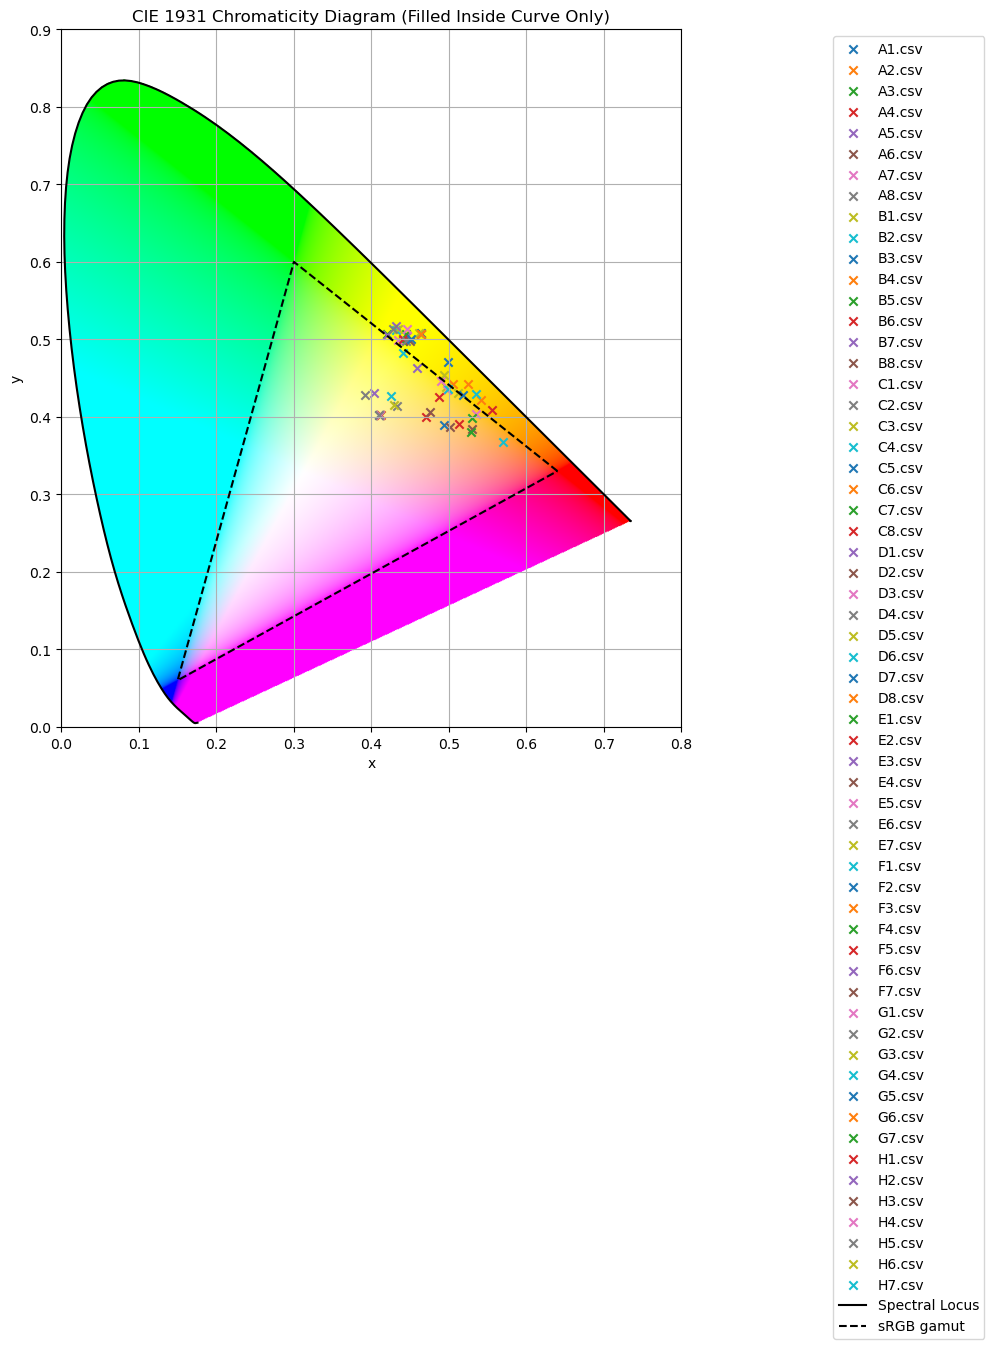

In [12]:
# Extract x, y chromaticity coordinates for all files
chromaticity_coordinates = {}

for file, df in dataframes.items():
    wavelengths = df['wavelength'].values
    intensities = df['intensity'].values
    x, y = spectrum_to_xy(wavelengths, intensities)
    chromaticity_coordinates[file] = (x, y)

# Display the results
for file, (x, y) in chromaticity_coordinates.items():
    print(f"File: {file}, Chromaticity coordinates (x, y): ({x}, {y})")

colors = ['red', 'green', 'blue', 'yellow'] # Define colors used
# Plot the x, y chromaticity coordinates
plt.figure(figsize=(8, 10))
#for file, (x, y) in chromaticity_coordinates.items():
   # if 0.4 <= x <= 0.5 and 0.3 <= y <= 0.4:
   #     plt.scatter(x, y, color='red', marker='x') # , label=f"{file}")
   # elif 0.25<= x <= 0.35 and 0.5 <= y <= 0.6:
   #     plt.scatter(x, y, color='green', marker='x')
  #  elif 0.15 <= x <= 0.25 and 0.1 <= y <= 0.4:
  #      plt.scatter(x, y, color='blue', marker='x') #, label=f"{file} ")
  #  elif 0.35 <= x <= 0.45 and 0.5 <= y <= 0.6:
 #       plt.scatter(x, y, color='orange', marker='x') # , label=f"{file}")
 #   else:
        # Default color for other points
for file, (x,y) in chromaticity_coordinates.items():
    #plt.scatter(x, y, color='k', marker='x') # , label=f"{file}")
    plt.scatter(x, y, marker='x',label=file)

    # # Overlay the sRGB primaries closed polygon
    # sRGB_polygon = plt.Polygon(sRGB_primaries_closed, color='grey', alpha=0.01, label='sRGB Gamut')
    # plt.gca().add_patch(sRGB_polygon)
plot_chromaticity_diagram()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Chromaticity Coordinates (x, y)')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

plt.grid(True)

# Generate background
xx, yy, RGB = generate_cie_1931_background()


# Mask the RGB values outside the spectral locus
spectral_path = get_spectral_locus_path()
xy_points = np.stack([xx.ravel(), yy.ravel()], axis=-1)
inside_mask = spectral_path.contains_points(xy_points).reshape(xx.shape)

# Set RGB values outside the spectral locus to white
RGB[~inside_mask] = 1.0

# Plot the chromaticity diagram with the masked RGB background
plt.imshow(RGB, extent=(0., 0.8, 0, 0.9), origin='lower')
plt.title("CIE 1931 Chromaticity Diagram (Filled Inside Curve Only)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.xlim(0, 0.8)
plt.ylim(0, 0.9)
plt.show()
